In [1]:
# processing
import operator
from operator import methodcaller
import csv
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import math
import itertools

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import HdpModel
from gensim.models import TfidfModel

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

# sci-kit
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import feature_extraction


C:\Users\pjz1\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [14]:
blacklist = [t.strip() for t in next(csv.reader(open("tools\\blacklist.csv", 'r')))]
levels = [1, 2, 3]

# format [term, orig, sentence, docID]
inPath = "v1.csv"

inFile = open(inPath, 'r')
inReader = csv.reader(inFile)

docTokens = dict()

# ignore headers
next(inReader)


for inRow in inReader:
    term = inRow[0]
    docID = inRow[3]
    
    
    # find acceptable tokens only
    token = "_".join([t for t in term.split(":") if re.match(r'[^\W\d]*$', t) and not t in blacklist])

    # calculate new term level
    level = token.count("_")

    # if acceptable, add to dictionary
    if level in levels and not token in blacklist and len(token) > 0:
        if docID in docTokens:
            docTokens[docID] += [token]
        else:
            docTokens[docID] = [token]
                        
docIDs = list(docTokens.keys())
texts = list(docTokens.values())


In [17]:
dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

### Coherence Testing

Find the ideal number of topics by performance cohernece tests on sample topic models.

0.41960392635679966
0.4067245065768361
0.43973822643802735
0.3919662097235229
0.45117870407504446
0.4486139491059005
0.416250406611232
0.4352812837453689
0.40224598518177096
0.4521765619769601
0.4598458839229249
0.4382769966303126
0.44604765623634535
0.47626223297781056
0.49398398254249704
0.46064859169501104
0.4820069470840728
0.49476488062503177
0.5014590552227493
0.4833628688462488


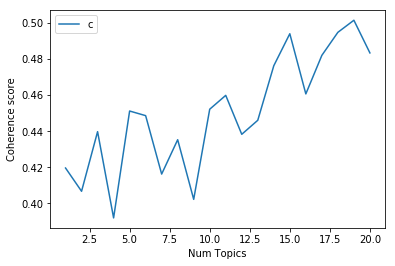

In [18]:
topics = range(1, 21)
passes = 5
iterations = 500

model_list = list()
coherence_values = list()

for topicnum in topics:

    model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topicnum, id2word=dictionary, passes=passes, workers =4, iterations=iterations)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    print(coherencemodel.get_coherence())
    coherence_values.append(coherencemodel.get_coherence())


plt.plot(topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
passes = [5, 8, 12, 20, 25, 32, 40, 50, 65, 80, 100]
coh1 = [0.7366002210076883, 0.7535347175289635, 0.7187085520419347, 0.7370655815312012, 0.7506638360329289, 0.723436962920069, 0.7047308664311466, 0.728423912120161, 0.7127082698428088, 0.7028986124848099, 0.7565239306707477]


coh2 = list()

for p in passes:
    
    model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes= p, workers =4, iterations=500)
    
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    print(coherencemodel.get_coherence())
    coh2.append(coherencemodel.get_coherence())

print(coh2)


In [ ]:
plt.plot(passes, coh1, 'r', label = "Unigrams")
plt.plot(passes, coh2, 'b', label = "R&R")
plt.xlabel("Passes")
plt.ylabel("Coherence score")
plt.legend()
plt.show()